In [1]:
from sklearn.manifold import TSNE
import numpy as np
import json

from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
import matplotlib.pyplot as plt


In [2]:
# load data from json (from scraper)
with open('./mnemonicscraper/mnemonicscraper/output.json') as json_file:
    data = json.load(json_file)

In [3]:
# Visual inspection
data[0]

{'title': 'Marketing Manager Benelux',
 'ingress': 'We are looking for a Marketing Manger who wants to join our Benelux expansion',
 'content': 'mnemonic is a well-established and acknowledged leader in the field of cybersecurity. We were established in 2000, and we’ve grown in a healthy rate ever since. We’re now more than 350 security experts and present in five European countries.As a global provider of cybersecurity services, mnemonic is widely recognised for our world-class Managed Detection and Response Services (MDR). With our flagship service – Argus Managed Defence – mnemonic is helping companies across Europe and the globe to protect their assets against increasingly advanced cybersecurity threats.With a loyal customer base across the Scandinavian region, mnemonic is now expanding its MDR service across the Benelux region, and the Netherlands is seen as a key region for strategic growth. We see an increasing demand for our service, and in 2023 alone we quadrupled our revenue 

In [4]:
# Create documents suitable for retrieval

page_content = []
metadatas = []

for i in data:
    content = f'{i["title"]} \n\n {i["ingress"]} \n\n {i["content"]} \n\n {i["url"]}'
    metadata = {
        "title": i["title"],
        "source": i["url"],
        "category": i["category"],
        "subcategory": i["subcategory"],
    }
    page_content.append(content)
    metadatas.append(metadata)
    

In [5]:
# Check documents
print(page_content[34])

Advisory: Critical RCE vulnerability in Apache Struts (CVE-2023-50164) 

 Critical vulnerability found in the widely used development framework for creating enterprise-ready Java web applications Apache Struts 

 On December 7th, 2023, Apache released an update that addresses a critical Remote Code Execution (RCE) vulnerability in Struts. The vulnerability is tracked as CVE-2023-50164 and has Apache Struts is a versatile framework for developing Java web applications, known for its efficiency in creating scalable and easily maintainable solutions. It follows a Model-View-Controller (MVC) architecture, and is widely utilised by various vendors in their product and services portfolio, and by organisations as in-house built applications.The vulnerability can be exploited by an attacker by manipulating file upload parameters, potentially leading to the upload of malicious files and subsequent server-side detonation (e.g. JSP files).At this time, mnemonic's assessment is that the vulnerabil

In [6]:
# Prepare for embedding and indexing
docs = [Document(page_content=content, metadata=metadata) for content, metadata in zip(page_content, metadatas)]

In [7]:
embeddings_model = OpenAIEmbeddings()

In [8]:
# save to disk
mnemonic_db = Chroma.from_documents(docs, embeddings_model, persist_directory="./mnemonic-rag/packages/retrieval-agent/retrieval_agent/mnemonic_db")
mnemonic_db.persist()

In [9]:
# Test stimilarity search
mnemonic_db.similarity_search("Data Science and machine learning", k=5)

[Document(page_content='Data Scientist \n\n Do you want to explore the possibilities of large amounts of security data? Join our R&D team! \n\n To reduce noise, improve detection and aid security analysts in their work, we need to utilise our data even better. The results will be crucial for defending the digital infrastructures we protect. Your work will be a crucial part of this work. At mnemonic, you will be part of:mnemonic responds to the region’s most serious cyberattacks. We work side by side with Europe’s most important organisations and critical infrastructure to protect them from the cyberattacks they see today, and what they can expect to see tomorrow.At more than 350 employees, we are amongst the largest pure play security companies in Europe, and continue to grow rapidly in Norway and internationally. In addition, we are continually ranked by Great Place to Work as one of Norway’s and Europe’s top workplaces.You will get the opportunity to work with a wide range of tasks, 

In [10]:
# Visualize the data by reducing the dimensionality with TSNE and adding category labels

# Get the embeddings and the categories

document_embeddings = mnemonic_db._collection.get(include=["embeddings"])['embeddings']
metadatas = mnemonic_db._collection.get(include=["metadatas"])['metadatas']
categories = [item['category'] for item in metadatas]


In [11]:
# Reduce the dimensionality with TSNE (from 1536 to 2 dimensions for visualization)
data = np.array(document_embeddings)
tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(data)

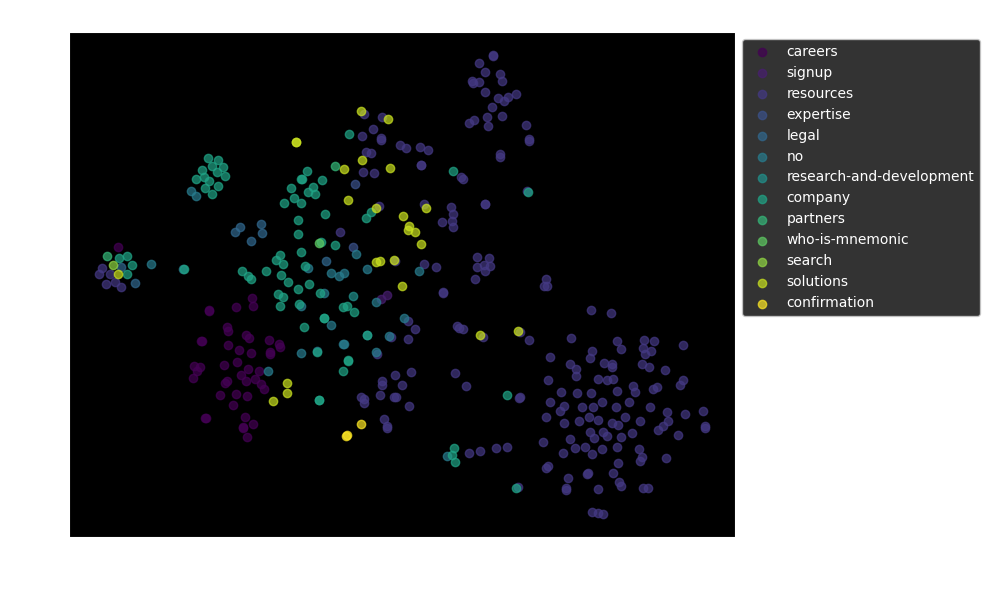

In [12]:
# Plot
unique_categories = list(set(categories))
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_categories)))
category_to_color = dict(zip(unique_categories, colors))

plt.figure(figsize=(10, 6))  
plt.style.use('dark_background')


for category, color in category_to_color.items():
    indices = [i for i, x in enumerate(categories) if x == category]
    plt.scatter(data_2d[indices, 0], data_2d[indices, 1], label=category, color=color, alpha=0.7)


plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2D visualization with Categories')

plt.tight_layout()

plt.show()